### Importing Dependencies + System Prep

In [35]:
import cv2
import torch
import random
import numpy as np
from ultralytics import YOLO
import matplotlib.pyplot as plt

In [36]:
# video_path = 'IMG_8873.MOV'
video_path = 'IMG_8896.MOV'

cap = cv2.VideoCapture(video_path)

# Get video properties
fps = int(cap.get(cv2.CAP_PROP_FPS))
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

cap.release()

### YOLOv3

In [53]:
# output_video_v3 = 'annotated_video_v3.mp4'
output_video_v3 = 'annotated_video_v3_2.mp4'

In [54]:
labels_path = 'archive/coco.names'
LABELS = open(labels_path).read().strip().split('\n')
np.random.seed(42)
colors = [(random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)) for j in range(len(LABELS))]

wts = 'archive/yolov3.weights'
cfg = 'archive/yolov3.cfg'
yolo_v3 = cv2.dnn.readNetFromDarknet(cfg, wts)

ln = yolo_v3.getLayerNames()
ln = [ln[i-1] for i in yolo_v3.getUnconnectedOutLayers()]

In [55]:
cap = cv2.VideoCapture(video_path)

# Get video properties
fps = int(cap.get(cv2.CAP_PROP_FPS))
W = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
H = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_video_v3, fourcc, fps, (width, height))

predictions_yolov3_raw = {}

# Read and display each frame of the video
frame_index = 0

while True:
    # Capture frame-by-frame
    ret, frame = cap.read()  # Read a frame from the video

    if not ret:
        break  # Break the loop if there are no more frames to read

    frame = cv2.resize(frame, None, fx=0.4, fy=0.4)
    height, width, channels = frame.shape

    blob = cv2.dnn.blobFromImage(frame, 1/255.0, (416, 416), swapRB=True, crop=False)
    yolo_v3.setInput(blob)
    layerOutputs = yolo_v3.forward(ln)

    boxes = []
    confidences = []
    classIDs = []
    labels = []

    for output in layerOutputs:
        for detection in output:
            scores = detection[5:]
            classID = np.argmax(scores)
            confidence = scores[classID]

            if confidence > 0.8:
                box = detection[0:4] * np.array([W, H, W, H])
                (centerX, centerY, width, height) = box.astype('int')
                x = int(centerX - (width/2))
                y = int(centerY - (height/2))
                boxes.append([x, y, int(width), int(height)])
                confidences.append(float(confidence))
                classIDs.append(classID)
                labels.append(LABELS[classID])

    idxs = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.3)
    predictions_yolov3_raw[frame_index] = ((labels, confidences))
    
    if len(idxs) > 0:
        for i in idxs.flatten():
            (x, y) = (boxes[i][0], boxes[i][1])
            (w, h) = (boxes[i][2], boxes[i][3])
            color = [int(c) for c in colors[classIDs[i]]]
            cv2.rectangle(frame, (x, y), (x+w, y+h), color, 2)
            text = "{}: {:.4f}".format(LABELS[classIDs[i]], confidences[i])
            cv2.putText(frame, text, (x, y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
    
    # Write the frame with bounding boxes to the output video
    out.write(frame)
    frame_index += 1

# Release the VideoCapture and VideoWriter objects
cap.release()
out.release()

print("Annotated video saved successfully.")

Annotated video saved successfully.


In [56]:
# Restructure predictions dictionary
predictions_yolov3 = {}

for frame_index, (labels, confidences) in predictions_yolov3_raw.items():
    predictions_yolov3[frame_index] = [(label, confidence) for label, confidence in zip(labels, confidences)]

### YOLOv5

In [41]:
yolo_v5 = torch.hub.load('ultralytics/yolov5', 'yolov5n', pretrained=True)

Using cache found in /Users/taqiya/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2024-4-30 Python-3.12.0 torch-2.3.0 CPU

Fusing layers... 
YOLOv5n summary: 213 layers, 1867405 parameters, 0 gradients, 4.5 GFLOPs
Adding AutoShape... 


In [42]:
# Output video file path
# output_video_v5 = 'annotated_video_v5.mp4'
output_video_v5 = 'annotated_video_v5_2.mp4'

In [43]:
# Open the video file
cap = cv2.VideoCapture(video_path)

# Get video properties
fps = int(cap.get(cv2.CAP_PROP_FPS))
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Check if the video file was successfully opened
if not cap.isOpened():
    print("Error: Could not open video file.")
    exit()

# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_video_v5, fourcc, fps, (width, height))

predictions_yolov5 = {}

# Read and display each frame of the video
frame_index = 0
while True:
    ret, frame = cap.read()  # Read a frame from the video

    if not ret:
        break  # Break the loop if there are no more frames to read

    # Perform object detection using YOLOv5
    results = yolo_v5(frame)
    predictions_yolov5[frame_index] = []

    # Draw bounding boxes on the frame for each detected object
    for i in range(len(results.pandas().xyxy[0])):
        xmin, ymin, xmax, ymax, conf, class_id, class_name = results.pandas().xyxy[0].loc[i, :]

        if conf >= 0.8:
            predictions_yolov5[frame_index].append((class_name, conf))

            # Convert coordinates to integers
            xmin, ymin, xmax, ymax = int(xmin), int(ymin), int(xmax), int(ymax)

            # Draw bounding box
            color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
            cv2.rectangle(frame, (xmin, ymin), (xmax, ymax), color, 2)

            # Add label
            label = f'{class_name}: {class_id}'
            cv2.putText(frame, label, (xmin, ymin - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    # Write the frame with bounding boxes to the output video
    out.write(frame)
    frame_index += 1

# Release the VideoCapture and VideoWriter objects
cap.release()
out.release()

print("Annotated video saved successfully.")

Annotated video saved successfully.


### YOLOv8

In [44]:
yolo_v8 = YOLO("yolov8n.pt")

In [45]:
# output_video_v8 = 'annotated_video_v8.mp4'
output_video_v8 = 'annotated_video_v8_2.mp4'

In [46]:
# Open the video file
cap = cv2.VideoCapture(video_path)

# Check if the video file was successfully opened
if not cap.isOpened():
    print("Error: Could not open video file.")
    exit()

# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_video_v8, fourcc, fps, (width, height))

predictions_yolov8 = {}

# Read and display each frame of the video
frame_index = 0
while True:
    ret, frame = cap.read()  

    if not ret:
        break 

    # Perform object detection using YOLOv5
    results = yolo_v8.predict(frame)
    predictions_yolov8[frame_index] = []

    for result in results:
        i = 0
        
        for r in result.boxes.data.tolist():
            x1, y1, x2, y2, conf, class_id = r
            x1 = int(x1)
            x2 = int(x2)
            y1 = int(y1)
            y2 = int(y2)
            class_id = int(class_id)
            label = result.names[class_id]

            if conf >= 0.8:
                predictions_yolov8[frame_index].append((label, conf))
                color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))

                cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)
                cv2.putText(frame, f'{result.names[class_id]}:{conf}', (x1, y1+20), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)
                
                i+= 1
            
    # Write the frame with bounding boxes to the output video
    out.write(frame)
    frame_index += 1

# Release the VideoCapture and VideoWriter objects
cap.release()
out.release()

print("Annotated video saved successfully.")


0: 640x384 6 cars, 1 truck, 74.1ms
Speed: 3.8ms preprocess, 74.1ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 7 cars, 60.5ms
Speed: 2.5ms preprocess, 60.5ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 6 cars, 49.5ms
Speed: 1.8ms preprocess, 49.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 6 cars, 51.6ms
Speed: 1.2ms preprocess, 51.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 6 cars, 60.5ms
Speed: 1.9ms preprocess, 60.5ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 6 cars, 54.7ms
Speed: 1.5ms preprocess, 54.7ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 7 cars, 55.8ms
Speed: 1.4ms preprocess, 55.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 6 cars, 1 truck, 48.6ms
Speed: 1.4ms preprocess, 48.6ms inference, 0.4ms postprocess per image at shape (1, 3, 

### YOLOv3 vs YOLOv5 vs YOLOv8

In [59]:
common_classes_per_frame = []

for frame_number in sorted(set(predictions_yolov5.keys()) | set(predictions_yolov8.keys()) | set(predictions_yolov3.keys())):
    yolov3_predictions = predictions_yolov3.get(frame_number, [])
    yolov5_predictions = predictions_yolov5.get(frame_number, [])
    yolov8_predictions = predictions_yolov8.get(frame_number, [])
    
    yolov3_classes = {item[0]: item[1] for item in yolov3_predictions}
    yolov5_classes = {item[0]: item[1] for item in yolov5_predictions}
    yolov8_classes = {item[0]: item[1] for item in yolov8_predictions}

    common_classes = yolov5_classes.keys() & yolov8_classes.keys() & yolov3_classes.keys()
    common_classes_with_confidence = {}

    for cls in common_classes:
        yolov3_confidence = yolov3_classes[cls]
        yolov5_confidence = yolov5_classes[cls]
        yolov8_confidence = yolov8_classes[cls]
        common_classes_with_confidence[cls] = (yolov5_confidence, yolov8_confidence, yolov3_confidence)

    if common_classes_with_confidence:  # Check if the dictionary is not empty
        common_classes_per_frame.append((frame_number, common_classes_with_confidence))

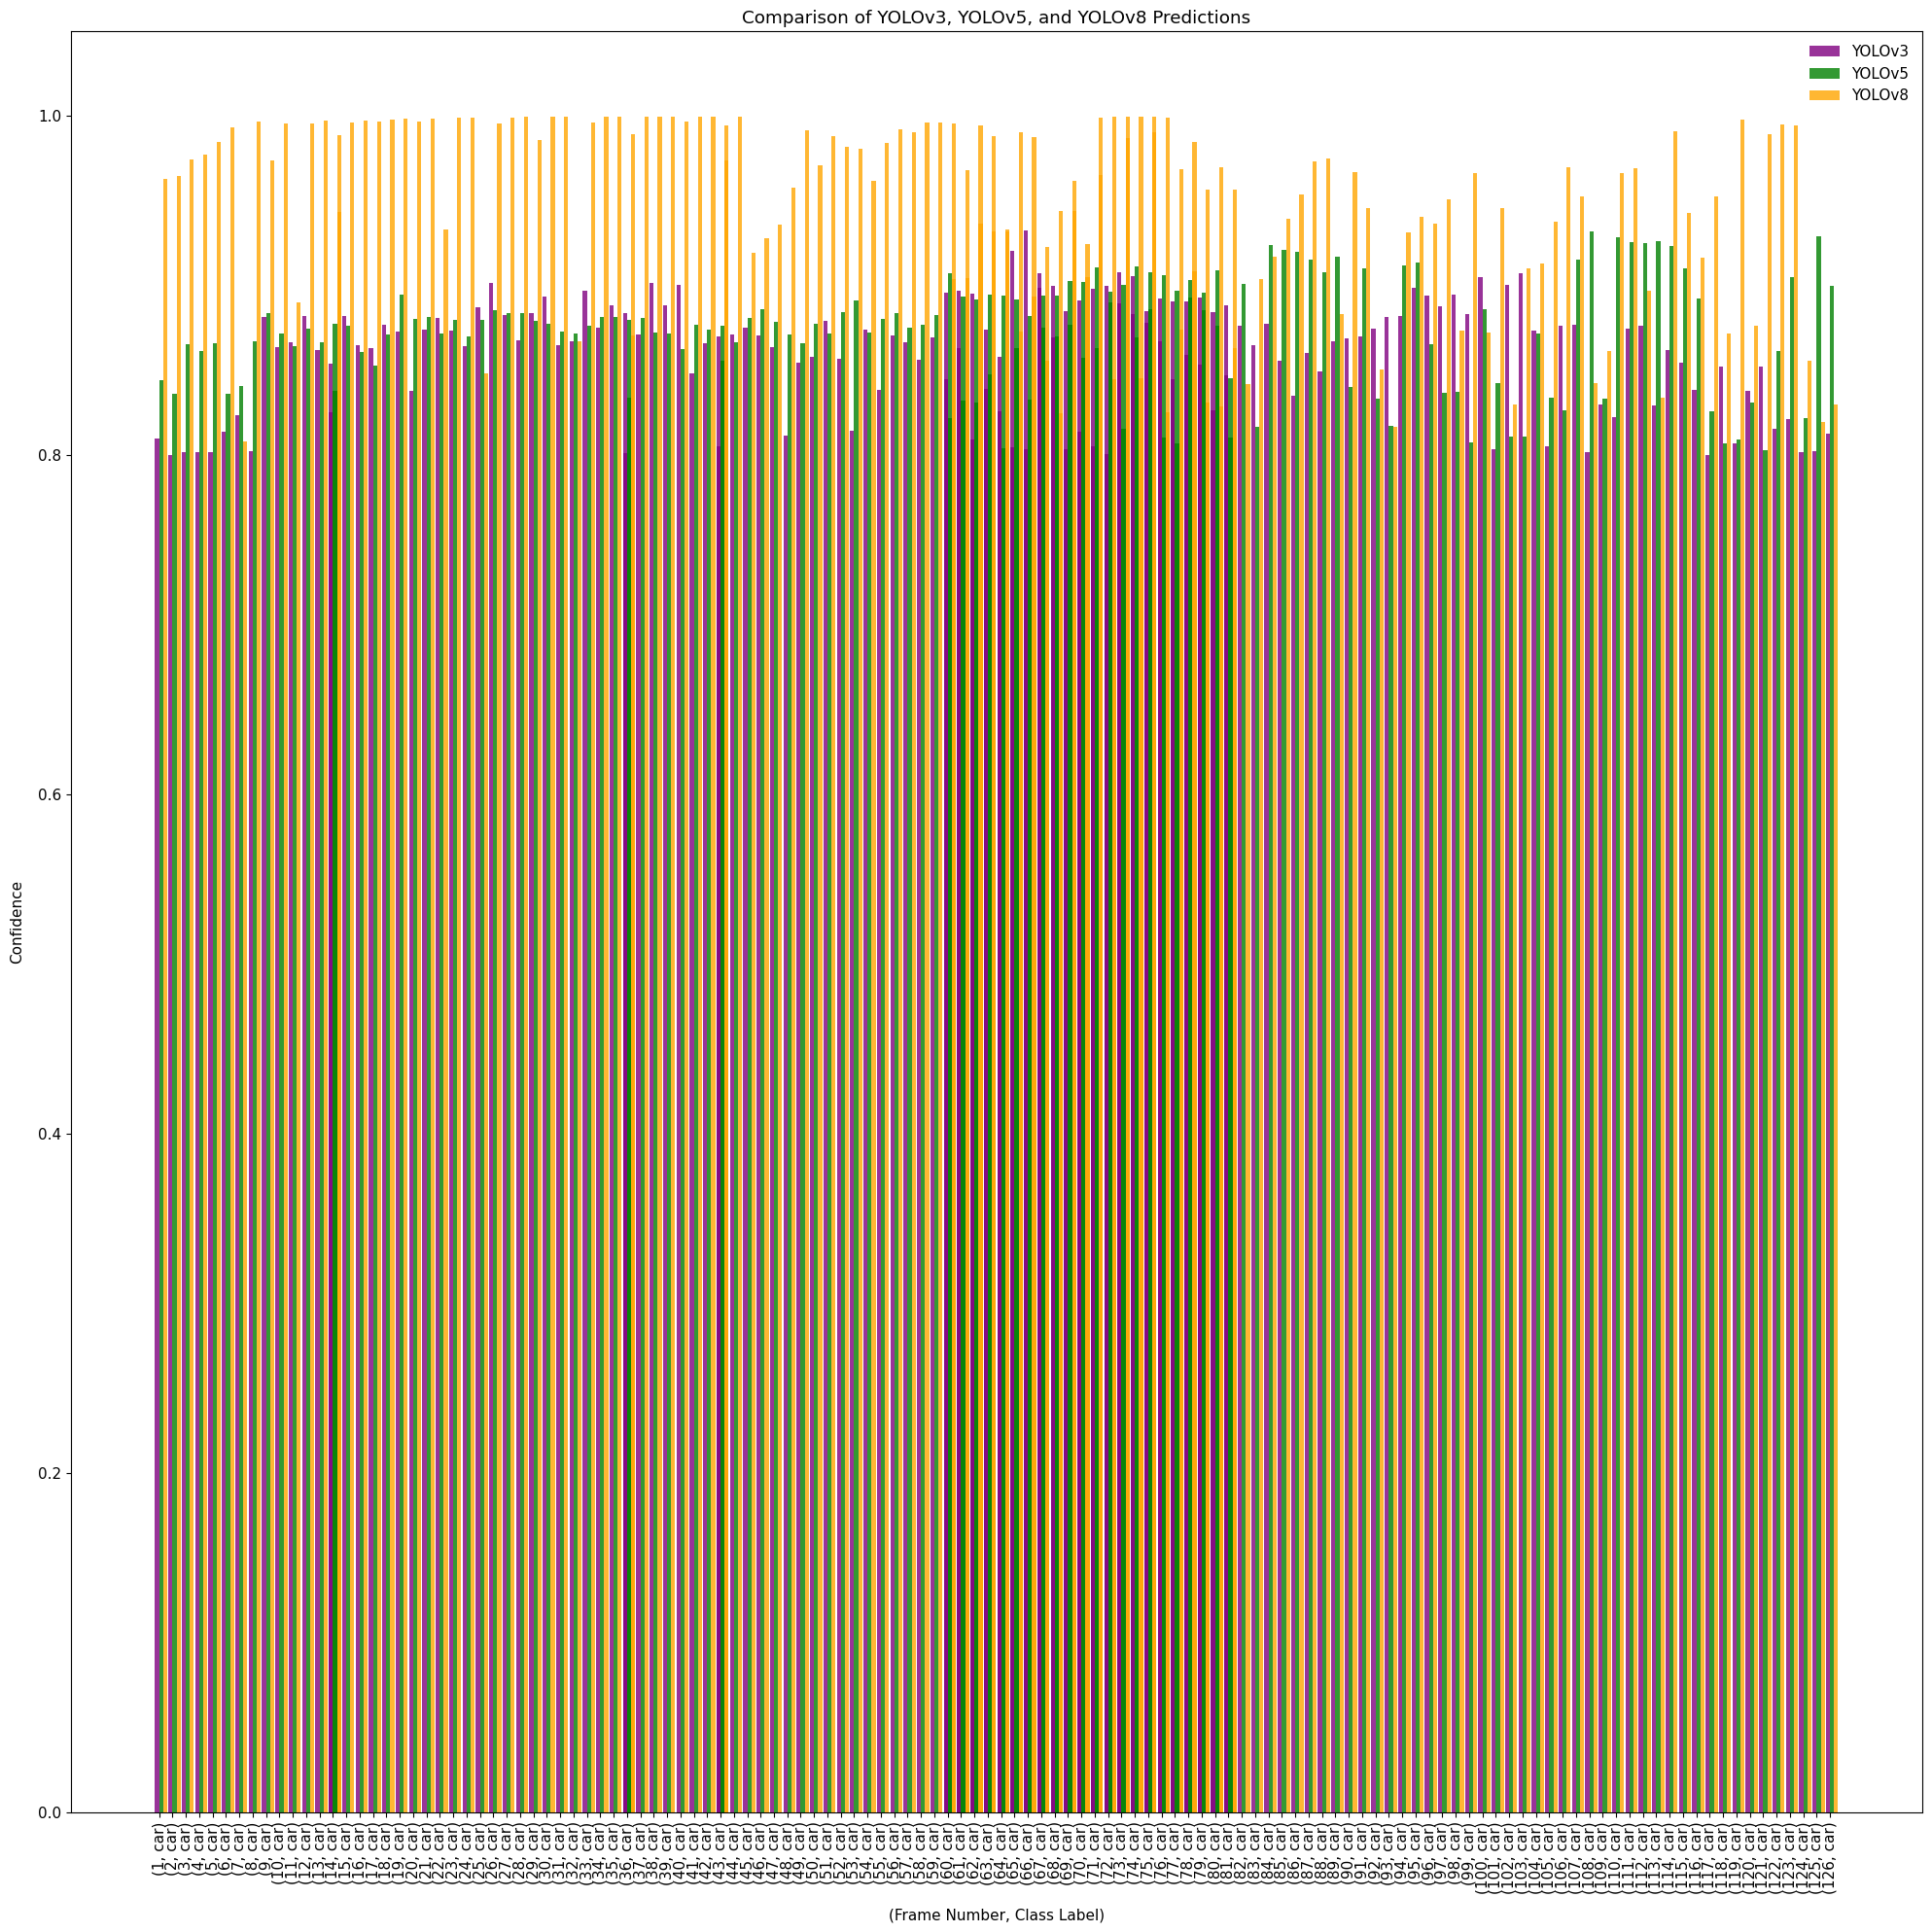

In [77]:
%matplotlib inline 

plt.figure(figsize=(20, 20))

bar_width = 0.35
opacity = 0.8

# Extracting classes and data
classes = list(common_classes_per_frame[0][1].keys())
num_classes = len(classes)
num_frames = len(common_classes_per_frame)

# Calculate x-axis positions
index = np.arange(1, num_frames + 1) * num_classes * (3 * bar_width + 0.1) + 0.1
class_index = np.arange(num_classes)

# Plotting
for i, (frame_number, common_classes_with_confidence) in enumerate(common_classes_per_frame):
    data = list(common_classes_with_confidence.values())
    yolov3_confidences = [d[0] for d in data]
    yolov5_confidences = [d[1] for d in data]
    yolov8_confidences = [d[2] for d in data]

    plt.bar(index[i] + class_index * (3 * bar_width), yolov3_confidences, bar_width, alpha=opacity, color='purple', label='YOLOv3' if i == 0 else '')
    plt.bar(index[i] + bar_width + class_index * (3 * bar_width), yolov5_confidences, bar_width, alpha=opacity, color='green', label='YOLOv5' if i == 0 else '')
    plt.bar(index[i] + (2 * bar_width) + class_index * (3 * bar_width), yolov8_confidences, bar_width, alpha=opacity, color='orange', label='YOLOv8' if i == 0 else '')

    # Add lines connecting the top of each bar plot
    plt.plot(index[i] + class_index * (3 * bar_width) + bar_width / 2, [max(yolov3_confidences)] * num_classes, color='purple', linestyle='-')
    plt.plot(index[i] + bar_width + class_index * (3 * bar_width) + bar_width / 2, [max(yolov5_confidences)] * num_classes, color='green', linestyle='-')
    plt.plot(index[i] + (2 * bar_width) + class_index * (3 * bar_width) + bar_width / 2, [max(yolov8_confidences)] * num_classes, color='orange', linestyle='-')

# Set x-tick labels as (frame number, class label)
tick_labels = [f"({frame_number+1}, {class_label})" for frame_number in range(num_frames) for class_label in classes]
plt.xticks(index + bar_width * num_classes / 2, tick_labels, rotation=90)

plt.xlabel('(Frame Number, Class Label)', labelpad=10)
plt.ylabel('Confidence', labelpad=10)
plt.title('Comparison of YOLOv3, YOLOv5, and YOLOv8 Predictions')
plt.legend(loc='best', frameon=False)
plt.tight_layout()
plt.show()

### Demo Instruction upon finding obstacle

In [32]:
# output_video_instructions = 'annotated_video_instructions.mp4'
output_video_instructions = 'annotated_video_instructions_2.mp4'

In [33]:
# Open the video file
cap = cv2.VideoCapture(video_path)

# Get video properties
fps = int(cap.get(cv2.CAP_PROP_FPS))
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Check if the video file was successfully opened
if not cap.isOpened():
    print("Error: Could not open video file.")
    exit()

# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_video_instructions, fourcc, fps, (width, height))

# Read and display each frame of the video
frame_index = 0
while True:
    ret, frame = cap.read()  

    if not ret:
        break 

    # Perform object detection using YOLOv5
    results = yolo_v8.predict(frame)
    predictions_yolov8[frame_index] = []

    for result in results:
        i = 0
        
        for r in result.boxes.data.tolist():
            x1, y1, x2, y2, conf, class_id = r
            x1 = int(x1)
            x2 = int(x2)
            y1 = int(y1)
            y2 = int(y2)
            class_id = int(class_id)
            label = result.names[class_id]

            if conf >= 0.8:
                predictions_yolov8[frame_index].append((label, conf))
                color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))

                cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)
                cv2.putText(frame, f'{result.names[class_id]}:{conf}', (x1, y1+20), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)

                text = f'Be careful, {label} detected!'
                print(text)
                cv2.putText(frame, text, (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 0), 5)

                i+= 1
        
    # Write the frame with bounding boxes to the output video
    out.write(frame)

# Release the VideoCapture and VideoWriter objects
cap.release()
out.release()

print("End of route -- you have reached safely!")


0: 640x384 6 cars, 1 truck, 88.0ms
Speed: 22.4ms preprocess, 88.0ms inference, 21.4ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 7 cars, 60.8ms
Speed: 1.4ms preprocess, 60.8ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 6 cars, 52.2ms
Speed: 1.5ms preprocess, 52.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 384)
Be careful, car detected!

0: 640x384 6 cars, 75.2ms
Speed: 1.6ms preprocess, 75.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 384)
Be careful, car detected!
Be careful, car detected!

0: 640x384 6 cars, 63.2ms
Speed: 1.3ms preprocess, 63.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 384)
Be careful, car detected!
Be careful, car detected!

0: 640x384 6 cars, 71.9ms
Speed: 2.0ms preprocess, 71.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 384)
Be careful, car detected!

0: 640x384 7 cars, 58.9ms
Speed: 1.5ms preprocess, 58.9ms inference, 0.8ms postprocess p

In [34]:
# output_video_instructions_15fps = 'annotated_video_instructions_15fps.mp4'
output_video_instructions_15fps = 'annotated_video_instructions_15fps_2.mp4'

# Open the video file
cap = cv2.VideoCapture('annotated_video_instructions_2.mp4')

# Get video properties
fps = 15
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Check if the video file was successfully opened
if not cap.isOpened():
    print("Error: Could not open video file.")
    exit()

# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_video_instructions_15fps, fourcc, 15, (width, height))

while True:
    ret, frame = cap.read()  

    if not ret:
        break  

    # Write the frame with bounding boxes to the output video
    out.write(frame)

# Release the VideoCapture and VideoWriter objects
cap.release()
out.release()